In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
train_data = pd.read_excel('Train_new.xlsx')

In [4]:
missing_values = train_data.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 Holiday               37398
Temperature               0
Rainfall_last_hour        0
Snowfall_last_hour        0
Cloud_Cover               0
Weather                   0
Weather_Desc              0
TimeStamp                 0
Date                      0
Traffic_Vol               0
dtype: int64


In [5]:
# Convert timestamp and date columns to datetime format
train_data['TimeStamp'] = pd.to_datetime(train_data['TimeStamp'], format='%d/%m/%y %H:%M')
train_data['Date'] = pd.to_datetime(train_data['Date'], format='%d/%m/%y')

In [6]:
train_data['Holiday'] = train_data.groupby('Date')['Holiday'].transform(lambda x: 1 if x.max() == 1 else 0)

In [7]:
verification = train_data.groupby('Date')['Holiday'].nunique()
inconsistent_dates = verification[verification > 1]
if inconsistent_dates.empty:
    print("All dates have consistent holiday values.")
else:
    print("Inconsistent holiday values found for dates:\n", inconsistent_dates)

All dates have consistent holiday values.


In [8]:
train_data.head()

,Holiday,Temperature,Rainfall_last_hour,Snowfall_last_hour,Cloud_Cover,Weather,Weather_Desc,TimeStamp,Date,Traffic_Vol
0,0,289.28,0.0,0.0,40,Cloudy skies,Partly cloudy skies,2008-10-02 09:00:00,2008-10-02,5555
1,0,290.26,0.0,0.0,75,Cloudy skies,Fragmented clouds,2008-10-02 10:00:00,2008-10-02,4525
2,0,290.28,0.0,0.0,90,Cloudy skies,Full cloud cover,2008-10-02 11:00:00,2008-10-02,4772
3,0,290.33,0.0,0.0,90,Cloudy skies,Full cloud cover,2008-10-02 12:00:00,2008-10-02,5031
4,0,292.14,0.0,0.0,75,Cloudy skies,Fragmented clouds,2008-10-02 13:00:00,2008-10-02,4928


In [9]:
# Feature engineering: Extract hour, day, and month from TimeStamp
train_data['Hour'] = train_data['TimeStamp'].dt.hour
train_data['Day'] = train_data['TimeStamp'].dt.day
train_data['Month'] = train_data['TimeStamp'].dt.month
train_data['Year'] = train_data['TimeStamp'].dt.year
train_data['Day_of_Week'] = train_data['TimeStamp'].dt.dayofweek

train_data['hour_sin'] = np.sin(2 * np.pi * train_data['Hour'] / 24)
train_data['hour_cos'] = np.cos(2 * np.pi * train_data['Hour'] / 24)
train_data['day_sin'] = np.sin(2 * np.pi * train_data['Day_of_Week'] / 7)
train_data['day_cos'] = np.cos(2 * np.pi * train_data['Day_of_Week'] / 7)

In [10]:
label_encoder = LabelEncoder()
train_data['Weather'] = label_encoder.fit_transform(train_data['Weather'])
train_data['Weather_Desc'] = label_encoder.fit_transform(train_data['Weather_Desc'])

In [11]:
train_data=train_data.drop(columns=['TimeStamp','Date'])

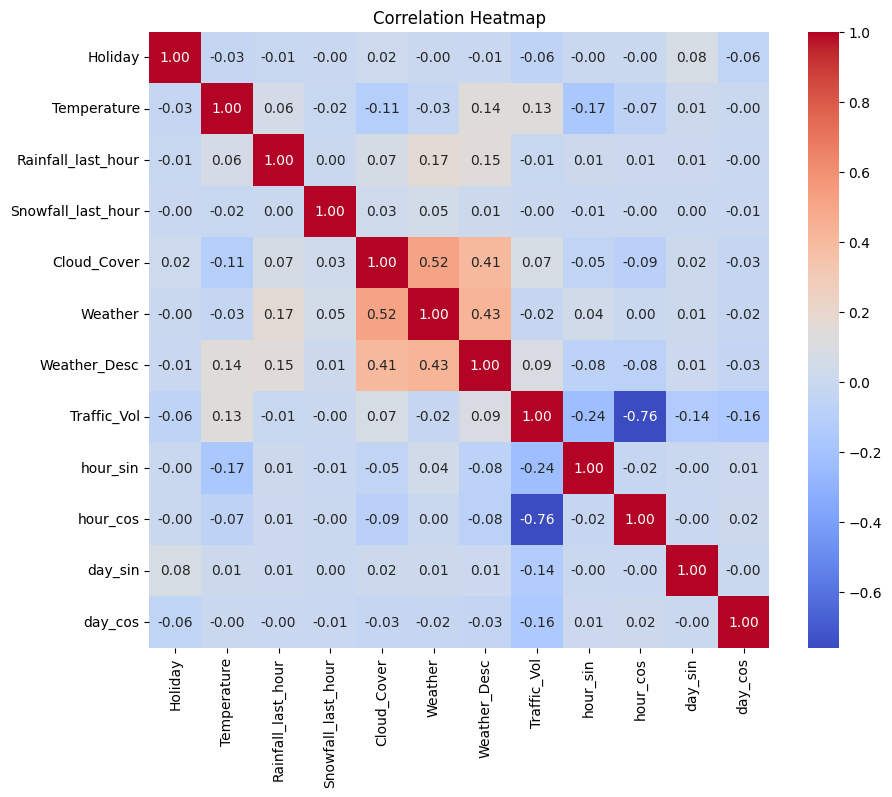

In [12]:
numerical_data=train_data.select_dtypes(include=['int64','float64'])
plt.figure(figsize=(10, 8))
corr = numerical_data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

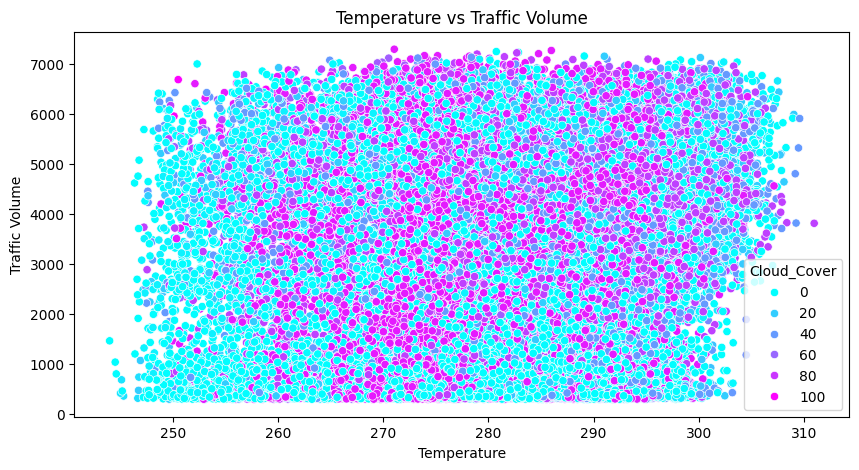

In [13]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=train_data, x='Temperature', y='Traffic_Vol', hue='Cloud_Cover', palette='cool')
plt.title('Temperature vs Traffic Volume')
plt.xlabel('Temperature')
plt.ylabel('Traffic Volume')
plt.show()

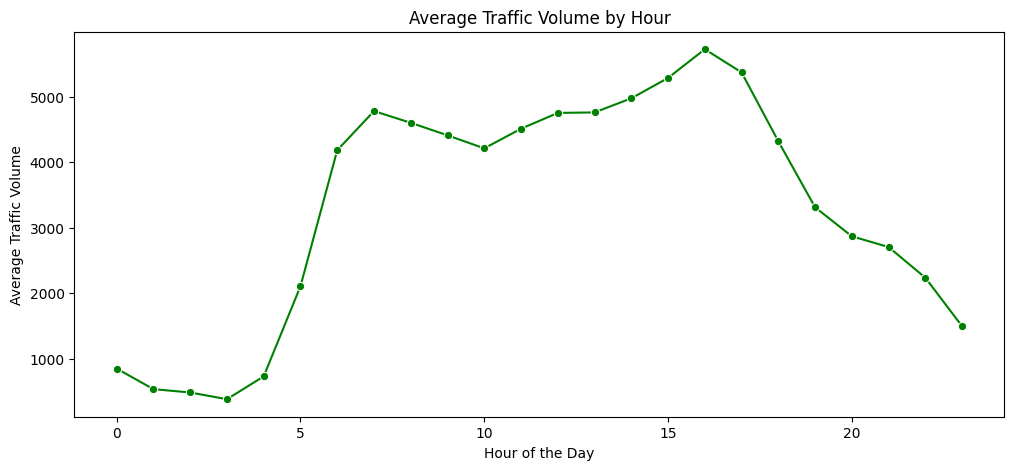

In [14]:
# Traffic Volume by Hour
hourly_data = train_data.groupby('Hour')['Traffic_Vol'].mean().reset_index()
plt.figure(figsize=(12, 5))
sns.lineplot(data=hourly_data, x='Hour', y='Traffic_Vol', marker='o', color='green')
plt.title('Average Traffic Volume by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Traffic Volume')
plt.show()

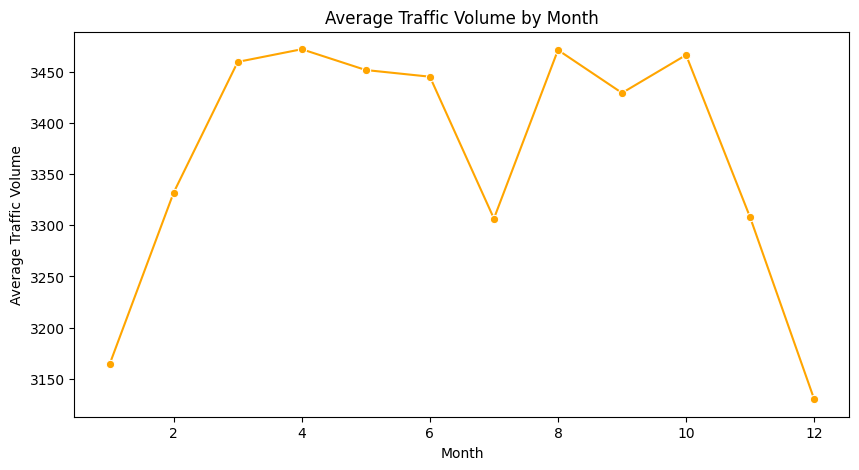

In [15]:
# Traffic Volume by Month
monthly_data = train_data.groupby('Month')['Traffic_Vol'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_data, x='Month', y='Traffic_Vol', marker='o', color='orange')
plt.title('Average Traffic Volume by Month')
plt.xlabel('Month')
plt.ylabel('Average Traffic Volume')
plt.show()

**Modelling Task**

In [16]:
# Import required libraries for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.api import OLS, add_constant
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
y= train_data['Traffic_Vol']
X=train_data.drop(columns=['Traffic_Vol'])

In [18]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

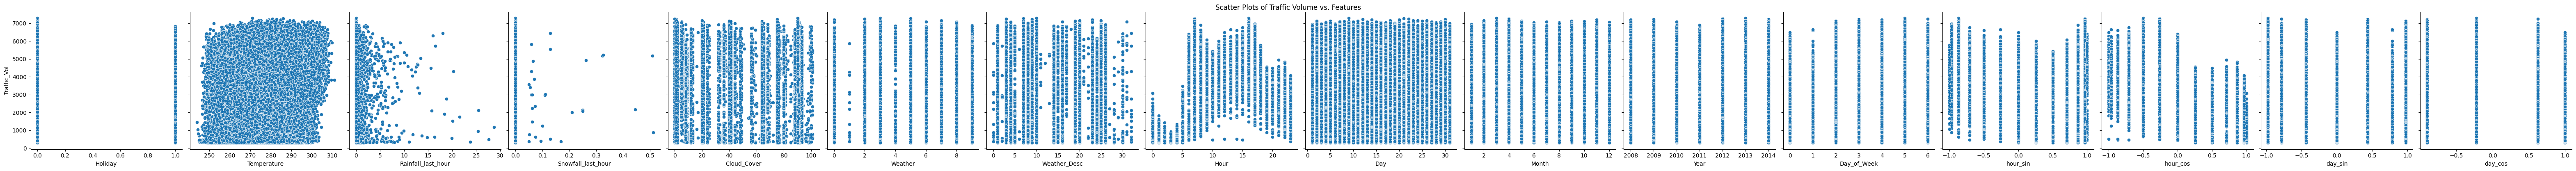

In [19]:
# Plot scatter plots to observe potential linear relationships
sns.pairplot(train_data, x_vars=X.columns, y_vars='Traffic_Vol', height=4, aspect=1, kind='scatter')
plt.suptitle("Scatter Plots of Traffic Volume vs. Features", y=1.02)
plt.show()

Modelling @ Serious

In [20]:
!pip install lightgbm xgboost scikit-learn optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.2 MB/s eta 0:00:00


In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.utils.validation import check_array
import optuna

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [22]:
# Helper function to evaluate models
def evaluate_model(model, X_val, y_val):
    predictions = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    mae = mean_absolute_error(y_val, predictions)
    r2 = r2_score(y_val, predictions)
    return {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    }

In [23]:
# Hyperparameter tuning for LightGBM
def tune_lightgbm(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, step=0.005),
        'num_leaves': trial.suggest_int('num_leaves', 31, 300, step=10),
        'max_depth': trial.suggest_int('max_depth', 3, 20, step=1),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 150, step=5),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 1e1, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0, step=0.05),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0, step=0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0, step=0.1)
    }
    model = LGBMRegressor(**param, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    return rmse

In [24]:
print("Tuning LightGBM with advanced parameters...")
lightgbm_study = optuna.create_study(direction='minimize')
lightgbm_study.optimize(tune_lightgbm, n_trials=50)
print("Best LightGBM Parameters:", lightgbm_study.best_params)

[I 2025-01-26 06:13:54,435] A new study created in memory with name: no-name-5bd2e015-36af-4b5c-a914-b0c948e2c79a


Tuning LightGBM with advanced parameters...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-01-26 06:13:56,523] Trial 0 finished with value: 356.77239656430606 and parameters: {'n_estimators': 300, 'learning_rate': 0.030000000000000002, 'num_leaves': 51, 'max_depth': 5, 'min_child_samples': 75, 'min_child_weight': 0.2462339792708977, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.8500000000000001, 'reg_alpha': 6.5, 'reg_lambda': 7.300000000000001}. Best is trial 0 with value: 356.77239656430606.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:14:09,792] Trial 1 finished with value: 289.56362906636406 and parameters: {'n_estimators': 900, 'learning_rate': 0.115, 'num_leaves': 251, 'max_depth': 7, 'min_child_samples': 25, 'min_child_weight': 0.35333040461859755, 'subsample': 0.9, 'colsample_bytree': 0.4, 'reg_alpha': 7.1000000000000005, 'reg_lambda': 6.1000000000000005}. Best is trial 1 with value: 289.56362906636406.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:14:17,016] Trial 2 finished with value: 325.75300504811116 and parameters: {'n_estimators': 800, 'learning_rate': 0.07, 'num_leaves': 111, 'max_depth': 4, 'min_child_samples': 5, 'min_child_weight': 6.259939084365921, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.65, 'reg_alpha': 5.1000000000000005, 'reg_lambda': 4.2}. Best is trial 1 with value: 289.56362906636406.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-01-26 06:14:24,887] Trial 3 finished with value: 356.62566290308405 and parameters: {'n_estimators': 1300, 'learning_rate': 0.065, 'num_leaves': 191, 'max_depth': 3, 'min_child_samples': 145, 'min_child_weight': 1.0163161728092336, 'subsample': 0.55, 'colsample_bytree': 0.55, 'reg_alpha': 3.3000000000000003, 'reg_lambda': 7.4}. Best is trial 1 with value: 289.56362906636406.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:14:34,112] Trial 4 finished with value: 276.4438582814798 and parameters: {'n_estimators': 700, 'learning_rate': 0.16, 'num_leaves': 141, 'max_depth': 14, 'min_child_samples': 120, 'min_child_weight': 7.119852845513812, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'reg_lambda': 1.6}. Best is trial 4 with value: 276.4438582814798.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:14:39,354] Trial 5 finished with value: 270.8503734394427 and parameters: {'n_estimators': 600, 'learning_rate': 0.085, 'num_leaves': 181, 'max_depth': 20, 'min_child_samples': 45, 'min_child_weight': 0.005097864119179308, 'subsample': 0.8, 'colsample_bytree': 0.65, 'reg_alpha': 5.2, 'reg_lambda': 1.3}. Best is trial 5 with value: 270.8503734394427.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:14:45,331] Trial 6 finished with value: 348.6271974515917 and parameters: {'n_estimators': 1400, 'learning_rate': 0.025, 'num_leaves': 281, 'max_depth': 4, 'min_child_samples': 140, 'min_child_weight': 1.5595720782979787, 'subsample': 1.0, 'colsample_bytree': 0.6000000000000001, 'reg_alpha': 6.300000000000001, 'reg_lambda': 7.1000000000000005}. Best is trial 5 with value: 270.8503734394427.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:14:48,352] Trial 7 finished with value: 276.1373713062493 and parameters: {'n_estimators': 600, 'learning_rate': 0.12000000000000001, 'num_leaves': 61, 'max_depth': 12, 'min_child_samples': 50, 'min_child_weight': 0.0014210724597951533, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.7000000000000001, 'reg_alpha': 2.9000000000000004, 'reg_lambda': 8.5}. Best is trial 5 with value: 270.8503734394427.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-01-26 06:14:49,209] Trial 8 finished with value: 391.80721282230866 and parameters: {'n_estimators': 200, 'learning_rate': 0.04, 'num_leaves': 121, 'max_depth': 4, 'min_child_samples': 85, 'min_child_weight': 0.8387365902986288, 'subsample': 0.9, 'colsample_bytree': 0.9500000000000001, 'reg_alpha': 5.300000000000001, 'reg_lambda': 9.4}. Best is trial 5 with value: 270.8503734394427.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777


[I 2025-01-26 06:14:50,660] Trial 9 finished with value: 304.9011768396985 and parameters: {'n_estimators': 300, 'learning_rate': 0.06, 'num_leaves': 61, 'max_depth': 14, 'min_child_samples': 80, 'min_child_weight': 0.2214462001898453, 'subsample': 0.8, 'colsample_bytree': 0.5, 'reg_alpha': 3.6, 'reg_lambda': 0.5}. Best is trial 5 with value: 270.8503734394427.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-01-26 06:15:04,683] Trial 10 finished with value: 279.28024504919415 and parameters: {'n_estimators': 1100, 'learning_rate': 0.2, 'num_leaves': 211, 'max_depth': 19, 'min_child_samples': 45, 'min_child_weight': 0.008977201028430354, 'subsample': 0.45, 'colsample_bytree': 1.0, 'reg_alpha': 9.1, 'reg_lambda': 3.1}. Best is trial 5 with value: 270.8503734394427.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:15:13,182] Trial 11 finished with value: 269.9002546554884 and parameters: {'n_estimators': 600, 'learning_rate': 0.12000000000000001, 'num_leaves': 191, 'max_depth': 20, 'min_child_samples': 50, 'min_child_weight': 0.0010025510101180626, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.7000000000000001, 'reg_alpha': 1.8, 'reg_lambda': 9.9}. Best is trial 11 with value: 269.9002546554884.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:15:18,342] Trial 12 finished with value: 271.5915192545792 and parameters: {'n_estimators': 500, 'learning_rate': 0.15, 'num_leaves': 191, 'max_depth': 20, 'min_child_samples': 55, 'min_child_weight': 0.0011591767822893859, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.75, 'reg_alpha': 0.5, 'reg_lambda': 3.3000000000000003}. Best is trial 11 with value: 269.9002546554884.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-01-26 06:15:23,722] Trial 13 finished with value: 269.2664251960306 and parameters: {'n_estimators': 500, 'learning_rate': 0.095, 'num_leaves': 231, 'max_depth': 17, 'min_child_samples': 30, 'min_child_weight': 0.014678123581479303, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8500000000000001, 'reg_alpha': 1.9000000000000001, 'reg_lambda': 0.1}. Best is trial 13 with value: 269.2664251960306.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:15:33,819] Trial 14 finished with value: 264.7751967390072 and parameters: {'n_estimators': 1000, 'learning_rate': 0.14, 'num_leaves': 241, 'max_depth': 16, 'min_child_samples': 5, 'min_child_weight': 0.023588089977719013, 'subsample': 0.65, 'colsample_bytree': 0.9, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 5.1000000000000005}. Best is trial 14 with value: 264.7751967390072.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:15:44,679] Trial 15 finished with value: 267.39900555188774 and parameters: {'n_estimators': 1000, 'learning_rate': 0.155, 'num_leaves': 241, 'max_depth': 16, 'min_child_samples': 10, 'min_child_weight': 0.03566495658065482, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.9, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 5.5}. Best is trial 14 with value: 264.7751967390072.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:15:58,061] Trial 16 finished with value: 271.4279000592197 and parameters: {'n_estimators': 1100, 'learning_rate': 0.16, 'num_leaves': 291, 'max_depth': 16, 'min_child_samples': 10, 'min_child_weight': 0.035408552695660574, 'subsample': 0.55, 'colsample_bytree': 0.9500000000000001, 'reg_alpha': 1.5, 'reg_lambda': 4.6000000000000005}. Best is trial 14 with value: 264.7751967390072.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:16:10,533] Trial 17 finished with value: 275.9282637625274 and parameters: {'n_estimators': 1000, 'learning_rate': 0.195, 'num_leaves': 251, 'max_depth': 9, 'min_child_samples': 20, 'min_child_weight': 0.05440192928895936, 'subsample': 0.4, 'colsample_bytree': 0.9, 'reg_alpha': 4.1000000000000005, 'reg_lambda': 5.9}. Best is trial 14 with value: 264.7751967390072.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-01-26 06:16:25,275] Trial 18 finished with value: 274.81043646437723 and parameters: {'n_estimators': 1200, 'learning_rate': 0.14, 'num_leaves': 251, 'max_depth': 17, 'min_child_samples': 100, 'min_child_weight': 0.027453154612719077, 'subsample': 0.6000000000000001, 'colsample_bytree': 1.0, 'reg_alpha': 0.9, 'reg_lambda': 5.6000000000000005}. Best is trial 14 with value: 264.7751967390072.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:16:34,900] Trial 19 finished with value: 266.8890871767229 and parameters: {'n_estimators': 1500, 'learning_rate': 0.17500000000000002, 'num_leaves': 161, 'max_depth': 11, 'min_child_samples': 5, 'min_child_weight': 0.08408178848944882, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_alpha': 2.1, 'reg_lambda': 3.2}. Best is trial 14 with value: 264.7751967390072.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:16:48,611] Trial 20 finished with value: 278.87139587821304 and parameters: {'n_estimators': 1500, 'learning_rate': 0.185, 'num_leaves': 161, 'max_depth': 10, 'min_child_samples': 30, 'min_child_weight': 0.09575433373333667, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_alpha': 2.6, 'reg_lambda': 2.6}. Best is trial 14 with value: 264.7751967390072.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:16:57,632] Trial 21 finished with value: 266.8323095526873 and parameters: {'n_estimators': 900, 'learning_rate': 0.17500000000000002, 'num_leaves': 231, 'max_depth': 14, 'min_child_samples': 5, 'min_child_weight': 0.004584071252591037, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.9, 'reg_alpha': 2.3000000000000003, 'reg_lambda': 4.0}. Best is trial 14 with value: 264.7751967390072.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:17:07,032] Trial 22 finished with value: 264.4648682229696 and parameters: {'n_estimators': 1400, 'learning_rate': 0.17500000000000002, 'num_leaves': 151, 'max_depth': 13, 'min_child_samples': 5, 'min_child_weight': 0.00596327040887212, 'subsample': 0.65, 'colsample_bytree': 0.8, 'reg_alpha': 4.1000000000000005, 'reg_lambda': 4.0}. Best is trial 22 with value: 264.4648682229696.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:17:21,472] Trial 23 finished with value: 271.4429516965331 and parameters: {'n_estimators': 1300, 'learning_rate': 0.135, 'num_leaves': 221, 'max_depth': 13, 'min_child_samples': 25, 'min_child_weight': 0.003348857221820361, 'subsample': 0.65, 'colsample_bytree': 0.9, 'reg_alpha': 3.7, 'reg_lambda': 4.3}. Best is trial 22 with value: 264.4648682229696.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:17:26,297] Trial 24 finished with value: 263.9581271921499 and parameters: {'n_estimators': 900, 'learning_rate': 0.18000000000000002, 'num_leaves': 91, 'max_depth': 15, 'min_child_samples': 15, 'min_child_weight': 0.0034031412690484885, 'subsample': 0.75, 'colsample_bytree': 0.8500000000000001, 'reg_alpha': 4.6000000000000005, 'reg_lambda': 3.9000000000000004}. Best is trial 24 with value: 263.9581271921499.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-01-26 06:17:29,017] Trial 25 finished with value: 281.319106713211 and parameters: {'n_estimators': 800, 'learning_rate': 0.18000000000000002, 'num_leaves': 31, 'max_depth': 15, 'min_child_samples': 65, 'min_child_weight': 0.013731100034479693, 'subsample': 0.75, 'colsample_bytree': 0.75, 'reg_alpha': 4.4, 'reg_lambda': 2.3000000000000003}. Best is trial 24 with value: 263.9581271921499.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-01-26 06:17:38,431] Trial 26 finished with value: 268.15658090540194 and parameters: {'n_estimators': 1200, 'learning_rate': 0.135, 'num_leaves': 91, 'max_depth': 12, 'min_child_samples': 35, 'min_child_weight': 0.002382485671772307, 'subsample': 0.75, 'colsample_bytree': 0.8500000000000001, 'reg_alpha': 8.3, 'reg_lambda': 5.1000000000000005}. Best is trial 24 with value: 263.9581271921499.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-01-26 06:17:43,707] Trial 27 finished with value: 262.71007731844327 and parameters: {'n_estimators': 1000, 'learning_rate': 0.165, 'num_leaves': 101, 'max_depth': 18, 'min_child_samples': 15, 'min_child_weight': 0.008846091333671395, 'subsample': 0.65, 'colsample_bytree': 0.75, 'reg_alpha': 6.0, 'reg_lambda': 6.7}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:17:51,951] Trial 28 finished with value: 267.9066918474282 and parameters: {'n_estimators': 1300, 'learning_rate': 0.17, 'num_leaves': 91, 'max_depth': 17, 'min_child_samples': 20, 'min_child_weight': 0.011230670517756627, 'subsample': 0.75, 'colsample_bytree': 0.75, 'reg_alpha': 5.9, 'reg_lambda': 6.6000000000000005}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:18:00,356] Trial 29 finished with value: 275.4758253079712 and parameters: {'n_estimators': 1200, 'learning_rate': 0.19, 'num_leaves': 91, 'max_depth': 18, 'min_child_samples': 65, 'min_child_weight': 0.002051469760147992, 'subsample': 0.65, 'colsample_bytree': 0.8500000000000001, 'reg_alpha': 8.0, 'reg_lambda': 8.0}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:18:10,322] Trial 30 finished with value: 280.5278155416946 and parameters: {'n_estimators': 1400, 'learning_rate': 0.2, 'num_leaves': 121, 'max_depth': 8, 'min_child_samples': 40, 'min_child_weight': 0.008293161087027831, 'subsample': 0.8, 'colsample_bytree': 0.75, 'reg_alpha': 7.0, 'reg_lambda': 3.6}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:18:19,752] Trial 31 finished with value: 263.4924134276599 and parameters: {'n_estimators': 1000, 'learning_rate': 0.14500000000000002, 'num_leaves': 141, 'max_depth': 15, 'min_child_samples': 15, 'min_child_weight': 0.020761966026204795, 'subsample': 0.65, 'colsample_bytree': 0.8, 'reg_alpha': 4.6000000000000005, 'reg_lambda': 5.0}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:18:26,739] Trial 32 finished with value: 265.4610024515022 and parameters: {'n_estimators': 1100, 'learning_rate': 0.165, 'num_leaves': 141, 'max_depth': 15, 'min_child_samples': 15, 'min_child_weight': 0.005756613842413368, 'subsample': 0.65, 'colsample_bytree': 0.8, 'reg_alpha': 4.4, 'reg_lambda': 6.6000000000000005}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-01-26 06:18:34,588] Trial 33 finished with value: 296.7132884118903 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'num_leaves': 141, 'max_depth': 18, 'min_child_samples': 20, 'min_child_weight': 0.017158182160528425, 'subsample': 0.55, 'colsample_bytree': 0.65, 'reg_alpha': 5.6000000000000005, 'reg_lambda': 4.800000000000001}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-01-26 06:18:40,373] Trial 34 finished with value: 280.1923852482885 and parameters: {'n_estimators': 900, 'learning_rate': 0.15, 'num_leaves': 111, 'max_depth': 13, 'min_child_samples': 30, 'min_child_weight': 0.0025639613777522804, 'subsample': 0.75, 'colsample_bytree': 0.4, 'reg_alpha': 4.7, 'reg_lambda': 3.9000000000000004}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:18:45,030] Trial 35 finished with value: 263.3767274997182 and parameters: {'n_estimators': 900, 'learning_rate': 0.11, 'num_leaves': 81, 'max_depth': 15, 'min_child_samples': 15, 'min_child_weight': 0.006613699773911434, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.7000000000000001, 'reg_alpha': 6.2, 'reg_lambda': 2.6}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:18:50,082] Trial 36 finished with value: 265.6008265845807 and parameters: {'n_estimators': 900, 'learning_rate': 0.10500000000000001, 'num_leaves': 71, 'max_depth': 18, 'min_child_samples': 15, 'min_child_weight': 0.21886070370571822, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.6000000000000001, 'reg_alpha': 6.800000000000001, 'reg_lambda': 2.1}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777


[I 2025-01-26 06:18:52,236] Trial 37 finished with value: 278.4892977875142 and parameters: {'n_estimators': 700, 'learning_rate': 0.125, 'num_leaves': 31, 'max_depth': 19, 'min_child_samples': 35, 'min_child_weight': 0.0037200382455674042, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.7000000000000001, 'reg_alpha': 7.6000000000000005, 'reg_lambda': 1.2000000000000002}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:18:57,398] Trial 38 finished with value: 279.70357894358875 and parameters: {'n_estimators': 700, 'learning_rate': 0.095, 'num_leaves': 81, 'max_depth': 15, 'min_child_samples': 115, 'min_child_weight': 0.0559411897590643, 'subsample': 0.9, 'colsample_bytree': 0.65, 'reg_alpha': 6.4, 'reg_lambda': 6.4}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-01-26 06:19:06,073] Trial 39 finished with value: 275.7013666293858 and parameters: {'n_estimators': 1000, 'learning_rate': 0.10500000000000001, 'num_leaves': 111, 'max_depth': 11, 'min_child_samples': 60, 'min_child_weight': 0.0017098843374596475, 'subsample': 0.8, 'colsample_bytree': 0.55, 'reg_alpha': 5.9, 'reg_lambda': 7.300000000000001}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:19:10,058] Trial 40 finished with value: 293.1865414329466 and parameters: {'n_estimators': 800, 'learning_rate': 0.08, 'num_leaves': 51, 'max_depth': 6, 'min_child_samples': 40, 'min_child_weight': 0.007879331450067055, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.7000000000000001, 'reg_alpha': 5.0, 'reg_lambda': 2.7}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:19:17,567] Trial 41 finished with value: 268.10908579865776 and parameters: {'n_estimators': 900, 'learning_rate': 0.185, 'num_leaves': 131, 'max_depth': 13, 'min_child_samples': 15, 'min_child_weight': 0.005830247913496559, 'subsample': 0.65, 'colsample_bytree': 0.8, 'reg_alpha': 4.0, 'reg_lambda': 4.2}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:19:29,381] Trial 42 finished with value: 270.7721105007854 and parameters: {'n_estimators': 1100, 'learning_rate': 0.165, 'num_leaves': 171, 'max_depth': 14, 'min_child_samples': 25, 'min_child_weight': 3.4695903722777444, 'subsample': 0.75, 'colsample_bytree': 0.8500000000000001, 'reg_alpha': 3.1, 'reg_lambda': 3.5}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:19:33,233] Trial 43 finished with value: 263.4035049011887 and parameters: {'n_estimators': 700, 'learning_rate': 0.15, 'num_leaves': 101, 'max_depth': 15, 'min_child_samples': 10, 'min_child_weight': 0.018509236157756875, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.75, 'reg_alpha': 4.9, 'reg_lambda': 1.8}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:19:36,985] Trial 44 finished with value: 264.8660440792058 and parameters: {'n_estimators': 700, 'learning_rate': 0.14500000000000002, 'num_leaves': 101, 'max_depth': 15, 'min_child_samples': 15, 'min_child_weight': 0.021069058260383425, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.75, 'reg_alpha': 5.4, 'reg_lambda': 1.4000000000000001}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:19:41,220] Trial 45 finished with value: 283.1115903711692 and parameters: {'n_estimators': 800, 'learning_rate': 0.125, 'num_leaves': 51, 'max_depth': 16, 'min_child_samples': 135, 'min_child_weight': 0.010672258817118828, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.6000000000000001, 'reg_alpha': 6.1000000000000005, 'reg_lambda': 1.9000000000000001}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-01-26 06:19:45,584] Trial 46 finished with value: 270.7820642579414 and parameters: {'n_estimators': 500, 'learning_rate': 0.055, 'num_leaves': 121, 'max_depth': 19, 'min_child_samples': 25, 'min_child_weight': 0.0034842324795660256, 'subsample': 0.8, 'colsample_bytree': 0.75, 'reg_alpha': 4.9, 'reg_lambda': 2.8000000000000003}. Best is trial 27 with value: 262.71007731844327.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:19:50,007] Trial 47 finished with value: 260.0466224419946 and parameters: {'n_estimators': 1000, 'learning_rate': 0.115, 'num_leaves': 81, 'max_depth': 17, 'min_child_samples': 10, 'min_child_weight': 0.034804235476691085, 'subsample': 0.75, 'colsample_bytree': 0.7000000000000001, 'reg_alpha': 7.300000000000001, 'reg_lambda': 0.6000000000000001}. Best is trial 47 with value: 260.0466224419946.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-01-26 06:19:54,171] Trial 48 finished with value: 262.7576155425192 and parameters: {'n_estimators': 1000, 'learning_rate': 0.115, 'num_leaves': 71, 'max_depth': 17, 'min_child_samples': 10, 'min_child_weight': 0.05563505734423397, 'subsample': 0.65, 'colsample_bytree': 0.65, 'reg_alpha': 9.600000000000001, 'reg_lambda': 0.9}. Best is trial 47 with value: 260.0466224419946.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [31, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 291].
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 15
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-01-26 06:19:59,015] Trial 49 finished with value: 280.05757015423967 and parameters: {'n_estimators': 600, 'learning_rate': 0.115, 'num_leaves': 71, 'max_depth': 18, 'min_child_samples': 90, 'min_child_weight': 0.48348778714228635, 'subsample': 0.9, 'colsample_bytree': 0.6000000000000001, 'reg_alpha': 9.600000000000001, 'reg_lambda': 0.7000000000000001}. Best is trial 47 with value: 260.0466224419946.


Best LightGBM Parameters: {'n_estimators': 1000, 'learning_rate': 0.115, 'num_leaves': 81, 'max_depth': 17, 'min_child_samples': 10, 'min_child_weight': 0.034804235476691085, 'subsample': 0.75, 'colsample_bytree': 0.7000000000000001, 'reg_alpha': 7.300000000000001, 'reg_lambda': 0.6000000000000001}


In [25]:
# Train final LightGBM model with best parameters
lightgbm_best_params = lightgbm_study.best_params
lightgbm_model = LGBMRegressor(**lightgbm_best_params, random_state=42)
lightgbm_model.fit(X_train, y_train)
lightgbm_results = evaluate_model(lightgbm_model, X_val, y_val)
print("\nLightGBM Performance (Advanced Tuning):", lightgbm_results)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [26]:
# Hyperparameter tuning for XGBoost
def tune_xgboost(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, step=0.005),
        'max_depth': trial.suggest_int('max_depth', 3, 20, step=1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10, step=1),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0, step=0.05),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0, step=0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0, step=0.1)
    }
    model = XGBRegressor(**param, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    return rmse

In [27]:
print("Tuning XGBoost with advanced parameters...")
xgboost_study = optuna.create_study(direction='minimize')
xgboost_study.optimize(tune_xgboost, n_trials=50)
print("Best XGBoost Parameters:", xgboost_study.best_params)

[I 2025-01-26 06:20:03,438] A new study created in memory with name: no-name-59a827d7-3dea-4969-ae7c-0256bd808214


Tuning XGBoost with advanced parameters...


[I 2025-01-26 06:21:29,039] Trial 0 finished with value: 300.7215671306267 and parameters: {'n_estimators': 1000, 'learning_rate': 0.02, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 1.0}. Best is trial 0 with value: 300.7215671306267.
[I 2025-01-26 06:21:56,151] Trial 1 finished with value: 278.8432719512881 and parameters: {'n_estimators': 1300, 'learning_rate': 0.02, 'max_depth': 19, 'min_child_weight': 8, 'subsample': 0.4, 'colsample_bytree': 0.55, 'reg_alpha': 0.9, 'reg_lambda': 5.5}. Best is trial 1 with value: 278.8432719512881.
[I 2025-01-26 06:22:02,018] Trial 2 finished with value: 278.3919224762098 and parameters: {'n_estimators': 1000, 'learning_rate': 0.155, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.9500000000000001, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 6.5}. Best is trial 2 with value: 278.3919224762098.
[I 2025-01-26 06:22:18,

Best XGBoost Parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 20, 'min_child_weight': 8, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.9, 'reg_alpha': 9.700000000000001, 'reg_lambda': 7.9}


In [28]:
# Train final XGBoost model with best parameters
xgboost_best_params = xgboost_study.best_params
xgboost_model = XGBRegressor(**xgboost_best_params, random_state=42)
xgboost_model.fit(X_train, y_train)
xgboost_results = evaluate_model(xgboost_model, X_val, y_val)
print("\nXGBoost Performance (Advanced Tuning):", xgboost_results)


XGBoost Performance (Advanced Tuning): {'RMSE': 264.2364737550439, 'MAE': 163.40283203125, 'R2': 0.9816657304763794}


In [29]:
# Blending Ensemble (Alternative to Stacking)
def blending_ensemble(models, X_val):
    predictions = [model.predict(X_val) for model in models]
    return np.mean(predictions, axis=0)

In [30]:
# Train the blending ensemble
print("\nBuilding Hybrid Model with Blending...")
models = [
    LGBMRegressor(**lightgbm_best_params, random_state=42).fit(X_train, y_train),
    XGBRegressor(**xgboost_best_params, random_state=42).fit(X_train, y_train)
]

blending_predictions = blending_ensemble(models, X_val)
blending_rmse = np.sqrt(mean_squared_error(y_val, blending_predictions))
print("\nBlending Model RMSE:", blending_rmse)


Building Hybrid Model with Blending...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759
[LightGBM] [Info] Number of data points in the train set: 28086, number of used features: 16
[LightGBM] [Info] Start training from score 3357.944777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

Prediction Goes Here

In [31]:
test_data = pd.read_csv('Test.csv')

In [32]:
missing_values = test_data.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 Holiday               2205
Temperature              0
Rainfall_last_hour       0
Snowfall_last_hour       0
Cloud_Cover              0
Weather                  0
Weather_Desc             0
TimeStamp                0
Date                     0
Traffic_Vol           2208
dtype: int64


In [33]:
test_data.columns

Index(['Holiday', 'Temperature', 'Rainfall_last_hour', 'Snowfall_last_hour',
       'Cloud_Cover', 'Weather', 'Weather_Desc', 'TimeStamp', 'Date',
       'Traffic_Vol'],
      dtype='object')

In [34]:
train_data.columns

Index(['Holiday', 'Temperature', 'Rainfall_last_hour', 'Snowfall_last_hour',
       'Cloud_Cover', 'Weather', 'Weather_Desc', 'Traffic_Vol', 'Hour', 'Day',
       'Month', 'Year', 'Day_of_Week', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos'],
      dtype='object')

In [35]:
# Convert timestamp and date columns to datetime format
test_data['TimeStamp'] = pd.to_datetime(test_data['TimeStamp'], format='%d/%m/%y %H:%M')
test_data['Date'] = pd.to_datetime(test_data['Date'], format='%d/%m/%y')

In [36]:
test_data['Holiday'] = test_data.groupby('Date')['Holiday'].transform(lambda x: 1 if x.max() == 1 else 0)

In [37]:
verification = test_data.groupby('Date')['Holiday'].nunique()
inconsistent_dates = verification[verification > 1]
if inconsistent_dates.empty:
    print("All dates have consistent holiday values.")
else:
    print("Inconsistent holiday values found for dates:\n", inconsistent_dates)

All dates have consistent holiday values.


In [38]:
# Feature engineering: Extract hour, day, and month from TimeStamp
test_data['Hour'] = test_data['TimeStamp'].dt.hour
test_data['Day'] = test_data['TimeStamp'].dt.day
test_data['Month'] = test_data['TimeStamp'].dt.month
test_data['Year'] = test_data['TimeStamp'].dt.year
test_data['Day_of_Week'] = test_data['TimeStamp'].dt.dayofweek

test_data['hour_sin'] = np.sin(2 * np.pi * test_data['Hour'] / 24)
test_data['hour_cos'] = np.cos(2 * np.pi * test_data['Hour'] / 24)
test_data['day_sin'] = np.sin(2 * np.pi * test_data['Day_of_Week'] / 7)
test_data['day_cos'] = np.cos(2 * np.pi * test_data['Day_of_Week'] / 7)

In [39]:
test_data=test_data.drop(columns=['TimeStamp','Date'])

In [40]:
missing_values = test_data.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 Holiday                  0
Temperature              0
Rainfall_last_hour       0
Snowfall_last_hour       0
Cloud_Cover              0
Weather                  0
Weather_Desc             0
Traffic_Vol           2208
Hour                     0
Day                      0
Month                    0
Year                     0
Day_of_Week              0
hour_sin                 0
hour_cos                 0
day_sin                  0
day_cos                  0
dtype: int64


In [41]:
label_encoder = LabelEncoder()
test_data['Weather'] = label_encoder.fit_transform(test_data['Weather'])
test_data['Weather_Desc'] = label_encoder.fit_transform(test_data['Weather_Desc'])

In [42]:
def prepare_test_predictions(test_data):
    print("Predicting on Test Data...")
    test_data_features = test_data.drop(columns=["Traffic_Vol"], errors="ignore")
    test_predictions = blending_ensemble(models, test_data_features)
    test_data["Traffic_Vol"] = test_predictions
    test_data[["Traffic_Vol"]].to_csv("Submission.csv", index=False)
    print("Predictions saved to Submission.csv")

# Prepare predictions for the test dataset
prepare_test_predictions(test_data)

Predicting on Test Data...
Predictions saved to Submission.csv
